In [1]:
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_swiss_roll
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from typing import Tuple
import seaborn as sns
from tqdm import trange
import torchvision
import torchvision.transforms as transforms
import os
import pandas as pd
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Lambda, Resize
from torchvision.datasets.mnist import MNIST, FashionMNIST

import diffusers
from dataclasses import dataclass
!pip install diffusers[training]==0.2.3
!pip install "ipywidgets>=7,<8"
import torch
import torchvision

# HuggingFace
import datasets
import diffusers
import accelerate

# Training and Visualization
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import PIL

@dataclass
class TrainingConfig:
    image_size=32 #Resize the digits to be a power of two
    train_batch_size = 32
    eval_batch_size = 32
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmpup_steps = 500
    mixed_precision = 'fp16'
    seed = 0
    
config = TrainingConfig()

data_dir = "./data"


print("pyTorch Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device Count:", torch.cuda.device_count())
    print("CUDA Current Device:", torch.cuda.current_device())
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
        

    print("pyTorch Version: ", torch.__version__)
    print("pyTorch CUDA Version: ", torch.version.cuda)
#torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

pyTorch Available: True
CUDA Device Count: 1
CUDA Current Device: 0
CUDA Device Name: NVIDIA GeForce RTX 4050 Laptop GPU
pyTorch Version:  2.5.1
pyTorch CUDA Version:  12.1
cuda


In [2]:
FASHION_CLASSES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def plot_image_grid(images, labels=None, ncols=10, figsize=(10, 10), title="", cmap=None, channels_first=True):
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    
    if channels_first and images.ndim == 4:
        images = np.moveaxis(images, 1, -1)
    
    images = images.squeeze()
    N = images.shape[0]
    nrows = int(np.ceil(N / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)
    axes = np.ravel(axes)
    
    if cmap is None and images.ndim == 3:
        cmap = "gray"

    for i in range(ncols * nrows):
        if i < N:
            axes[i].imshow(images[i], cmap=cmap)
            if labels is not None and i < len(labels):
                class_name = FASHION_CLASSES[labels[i]] if labels[i] < 10 else "Unknown"
                axes[i].set_title(f"{labels[i]}: {class_name}", fontsize=8)
        axes[i].axis("off")

    fig.suptitle(title, fontsize=12)
    plt.show()


In [3]:
transforms_input = Compose([
    ToTensor(),
    Resize([28,28]),
    Lambda(lambda img: (img-0.5) * 2), # Images will be scaled in range [-1,1]
])

data_dir = "./data"


# Fashion MNIST dataset.
train_df = FashionMNIST(data_dir, download=True, train=True, transform=transforms_input)
test_df = FashionMNIST(data_dir, download=True, train=False, transform=transforms_input)


train_dataset = torch.utils.data.DataLoader(train_df, batch_size=64)
test_dataset = torch.utils.data.DataLoader(test_df, batch_size=16)

torch.Size([64, 1, 28, 28]) torch.Size([64])


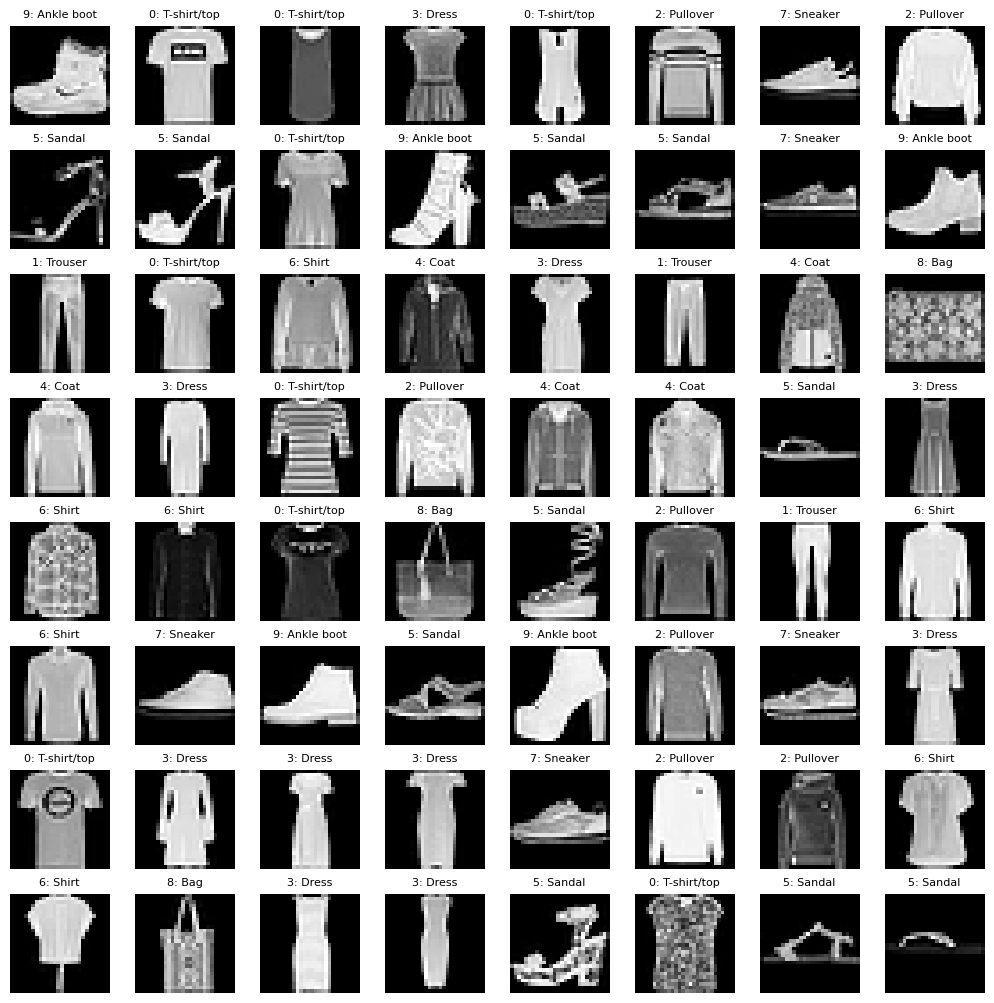

In [4]:
temp_imgs, temp_targets = next(iter(train_dataset))
# temp_targets = torch.tensor(list(temp_targets))
print(temp_imgs.shape, temp_targets.shape)
plot_image_grid(temp_imgs, temp_targets, ncols=8)

In [5]:
class DenoisingDiffusionProbabilisticModel(torch.nn.Module):
    def __init__(self, model_generator, beta_range=[1e-4, 2e-2], num_time_steps=100, device="cpu", image_shape=[1,28,28]):
        super(DenoisingDiffusionProbabilisticModel, self).__init__()
        self.model_generator = model_generator.to(device)
        self.beta_range = beta_range
        self.num_time_steps = num_time_steps
        self.device = device
        self.image_shape = image_shape

        self.betas = torch.linspace(start=beta_range[0], end=beta_range[1], steps=num_time_steps).to(device)
        self.alphas = (1 - self.betas).to(device)
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(device)
    
    def forward(self, x0, t, epsilon=None):
        n, c, h, w = x0.shape
        
        alpha_bar_t = self.alpha_bars[t].view(-1, 1, 1, 1)

        if epsilon is None:
            epsilon = torch.randn_like(x0, device=self.device)  # Generate noise if not provided
        
        try:
            x_t = alpha_bar_t.sqrt() * x0 + (1 - alpha_bar_t).sqrt() * epsilon
        except Exception as e:
            raise RuntimeError(f"Error computing x_t. Shapes: x0={x0.shape}, alpha_bar_t={alpha_bar_t.shape}, epsilon={epsilon.shape}") from e
        
        return x_t
    
    def backward(self, x, t):
        return self.model_generator(x.to(self.device), t.to(self.device))
        

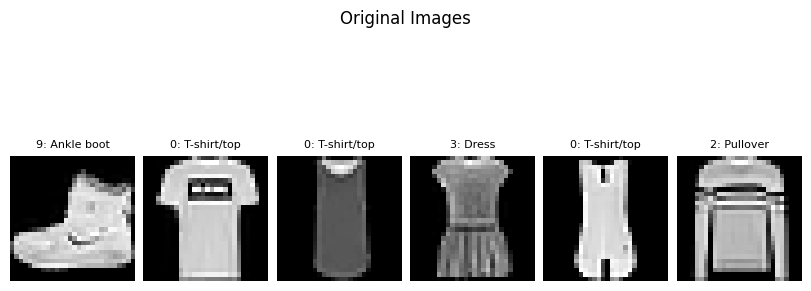

tensor([0, 0, 0, 0, 0, 0])


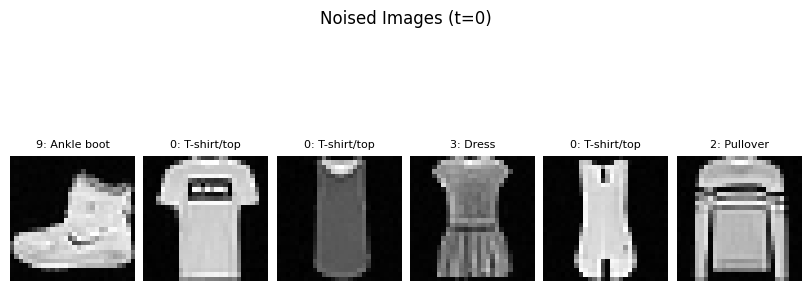

tensor([5, 5, 5, 5, 5, 5])


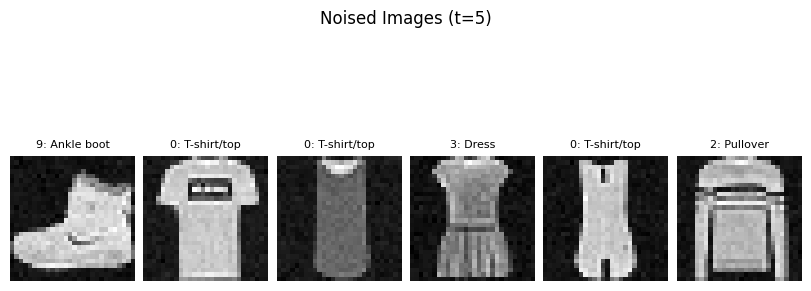

tensor([10, 10, 10, 10, 10, 10])


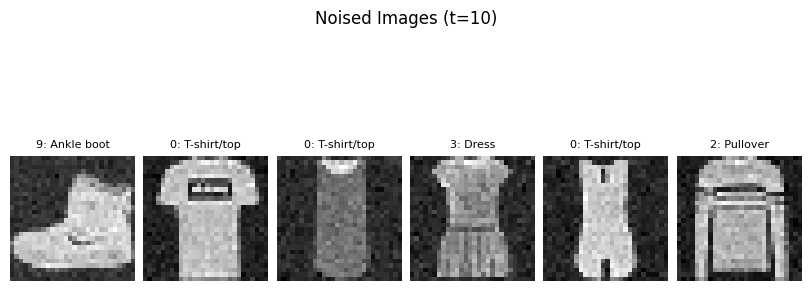

tensor([15, 15, 15, 15, 15, 15])


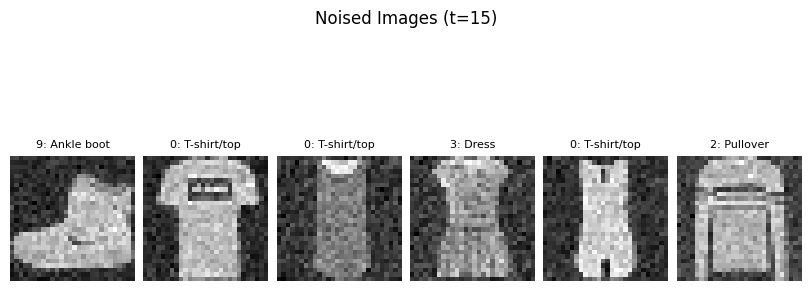

tensor([20, 20, 20, 20, 20, 20])


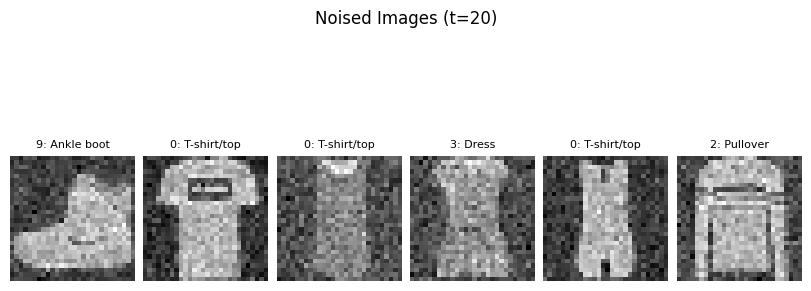

tensor([30, 30, 30, 30, 30, 30])


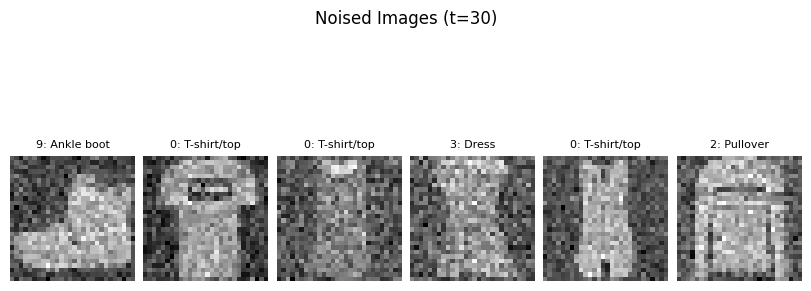

tensor([40, 40, 40, 40, 40, 40])


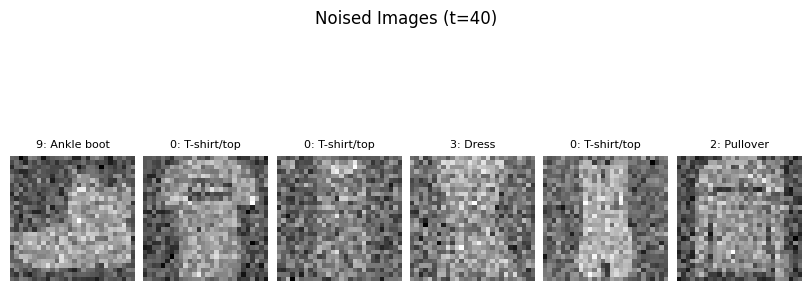

tensor([50, 50, 50, 50, 50, 50])


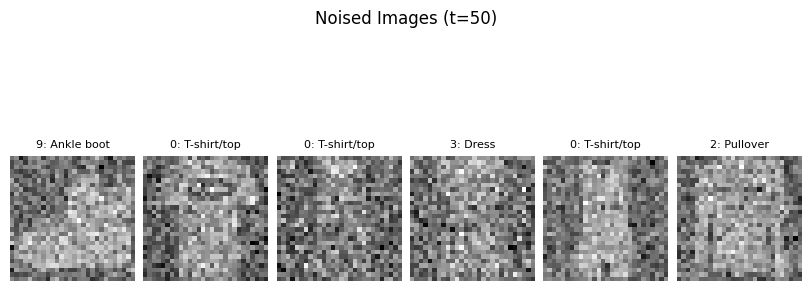

tensor([60, 60, 60, 60, 60, 60])


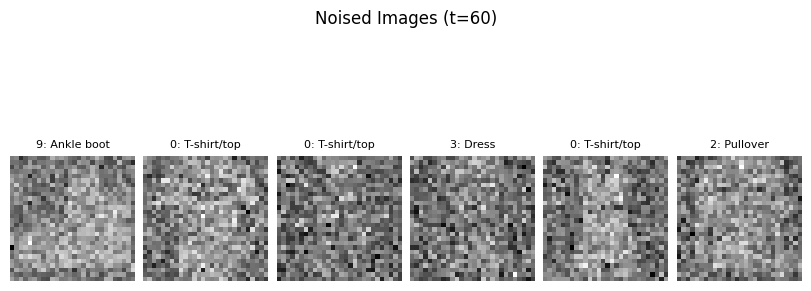

tensor([70, 70, 70, 70, 70, 70])


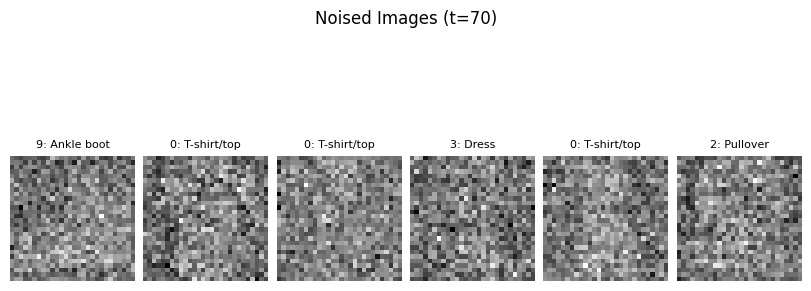

tensor([80, 80, 80, 80, 80, 80])


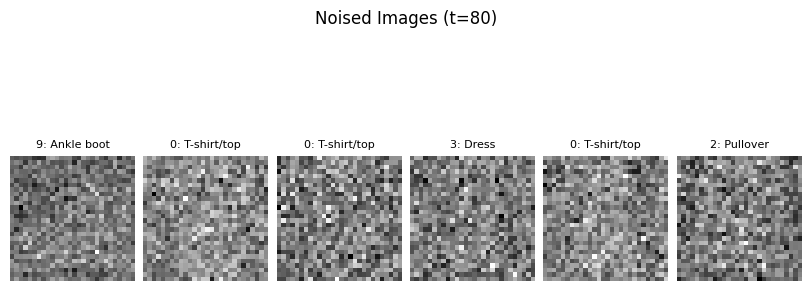

tensor([90, 90, 90, 90, 90, 90])


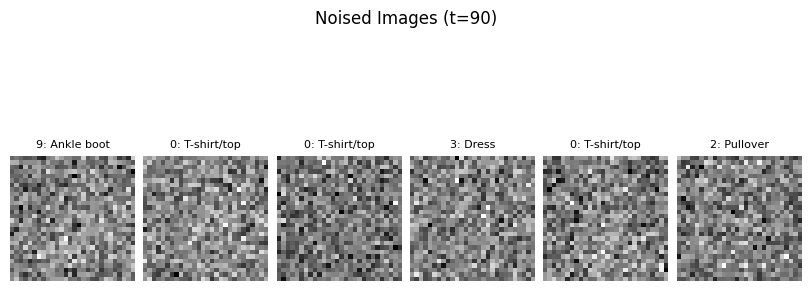

In [6]:
BATCH_SIZE = 6
NUM_STEPS = 100
IMAGE_SHAPE = [3,28,28]
dl_train = torch.utils.data.DataLoader(train_df, batch_size=BATCH_SIZE)
temp_imgs, temp_targets = next(iter(dl_train))

model = DenoisingDiffusionProbabilisticModel(torch.Tensor([1]), num_time_steps=NUM_STEPS, image_shape=IMAGE_SHAPE)

# Plot initial original images.
plot_image_grid(temp_imgs, temp_targets, ncols=6, title="Original Images", figsize=(8,4))

# Plot images at certain 't' noise level.
x_t = temp_imgs
for t in [0,5,10,15,20,30,40,50,60,70,80,90]:
    t_vec = torch.Tensor([t]*BATCH_SIZE).long()
    print(t_vec)
    x_t = model(x_t, t_vec)
    plot_image_grid(x_t, temp_targets, ncols=6, title=f"Noised Images (t={t})", figsize=(8,4))

In [9]:
def train(model_ddpm, loss_fn, optimizer, dl, t_num_steps, batch_size, device, lr_scheduler):
    model_ddpm.train()
    model_ddpm = model_ddpm.to(device)
    N = len(dl)
    losses = []
    for iter_id, (imgs, label) in enumerate(dl):
        imgs = imgs.to(device)
        t = torch.randint(0, t_num_steps, (batch_size,)).to(device)
        epsilon = torch.randn_like(imgs).to(device)

        x_t = model_ddpm(imgs, t, epsilon)
        epsilon_pred = model_ddpm.backward(x_t, t)        

        loss = loss_fn(epsilon_pred, epsilon)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_val = float(loss.detach().cpu().numpy())
        losses.append(loss_val)
        print(f"Train {iter_id+1}/{N} loss:{loss_val}", end="\r")
        if lr_scheduler is not None:
            lr_scheduler.step()
    mean_loss = np.mean(losses)
    return mean_loss


def eval(model_ddpm, loss_fn, optimizer, dl, t_num_steps, batch_size, device):
    model_ddpm.eval()
    model_ddpm = model_ddpm.to(device)
    N = len(dl)
    losses = []
    with torch.no_grad():
        for iter_id, (imgs, label) in enumerate(dl):
            imgs = imgs.to(device)
            t = torch.randint(0, t_num_steps, (batch_size,)).to(device)
            x_t = model_ddpm(imgs, t)
            epsilon_pred = model_ddpm.backward(x_t, t)
            epsilon = torch.randn_like(epsilon_pred)

            loss = loss_fn(epsilon_pred, epsilon)
            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()

            loss_val = float(loss.detach().cpu().numpy())
            losses.append(loss_val)
            print(f"Eval {iter_id+1}/{N} loss:{loss_val}", end="\r")
    mean_loss = np.mean(losses)
    return mean_loss

def generate_images(model_ddpm, num_imgs, device, sample_freq=4):
    model_ddpm.eval()
    alphas = model_ddpm.alphas
    alpha_bars = model_ddpm.alpha_bars    
    
    x = torch.randn([num_imgs, *model_ddpm.image_shape]).to(device)
    generated_img_improvements = [x.detach().cpu().numpy()]
    time_steps_improvements = [model_ddpm.num_time_steps]
    # Keep on removing noise for given number of time steps
    with torch.no_grad():
        for t in range(model_ddpm.num_time_steps-1, 0, -1):
            time_vec = (torch.ones(num_imgs) * t).long()
            epsilon_pred = model_ddpm.backward(x, time_vec)

            alpha_t = alphas[t]
            alpha_bar_t = alpha_bars[t]
            z = torch.randn_like(epsilon_pred)
            x = (1 / alpha_t.sqrt()) * (x - ((1 - alpha_t) / (1 - alpha_bar_t).sqrt()) * epsilon_pred) 
            if t > 0:
                # Random noise is not added for last image as that is final image.
                x = x + (1 - alpha_t).sqrt() * z

            if t % sample_freq == 0:
                generated_img_improvements.append(x.detach().cpu().numpy())
                time_steps_improvements.append(t)
    # Add final image.
    generated_img_improvements.append(x.detach().cpu().numpy())
    time_steps_improvements.append(t)
    return generated_img_improvements, time_steps_improvements

In [13]:
BATCH_SIZE = 64
NUM_STEPS = 1000
T_DIM = 100
LEARNING_RATE = 0.001
EPOCHS = 100
IMAGE_SHAPE = [1,28,28]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device:{device}")

dl_train = torch.utils.data.DataLoader(train_df, batch_size=BATCH_SIZE, drop_last=True,
                                      num_workers=20,
                                      prefetch_factor=512,
                                      persistent_workers=True
                                      )
dl_test = torch.utils.data.DataLoader(test_df, batch_size=BATCH_SIZE, drop_last=True,
                                      num_workers=20,
                                      prefetch_factor=512,
                                      persistent_workers=True
                                    )

model_generator = MyUNet(n_steps=NUM_STEPS, time_emb_dim=T_DIM, image_shape=IMAGE_SHAPE)
model_ddpm = DenoisingDiffusionProbabilisticModel(model_generator, num_time_steps=NUM_STEPS, device=device, image_shape=IMAGE_SHAPE)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_ddpm.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.SGD(model_ddpm.parameters(), lr=LEARNING_RATE, momentum=0.9)

# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, last_epoch=- 1, verbose=True)
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=2000, step_size_down=None, 
                                  mode='triangular2', gamma=0.1, scale_fn=None, scale_mode='cycle', cycle_momentum=False, 
                                  base_momentum=0.8, max_momentum=0.9, last_epoch=- 1, verbose=False)
# lr_scheduler = None

Using device:cuda


In [14]:
losses_train = []
losses_val = []
lr_list = []
for epoch in range(EPOCHS):
    epoch_loss_train = train(model_ddpm, loss_fn, optimizer, dl=dl_train, t_num_steps=NUM_STEPS, batch_size=BATCH_SIZE, 
                             device=device, lr_scheduler=lr_scheduler)
    epoch_loss_val = eval(model_ddpm, loss_fn, optimizer, dl=dl_val, t_num_steps=NUM_STEPS, batch_size=BATCH_SIZE, device=device)
    losses_train.append(epoch_loss_train)
    losses_val.append(epoch_loss_val)
    print(f"Epoch {epoch}/{EPOCHS} loss_train:{epoch_loss_train} loss_val:{epoch_loss_val} current lr:{optimizer.param_groups[0]['lr']}")
    
    # Update learning rate @ each epoch.
    lr_list.append(optimizer.param_groups[0]["lr"])
#     lr_scheduler.step()
    
    if epoch % 5 == 0 or epoch==EPOCHS-1:
        
        gen_imgs, time_steps = generate_images(model_ddpm, num_imgs=4, device=device, sample_freq=NUM_STEPS)
        for _imgs, _t_steps in zip(gen_imgs, time_steps):
            _gen_step = len(time_steps) - _t_steps + 1
            plot_image_grid(_imgs, None, ncols=4, title=f"Generated Imgs after {_t_steps} iter", 
                            figsize=(4,2)
                           )
        plt.show()
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5))
        ax = np.ravel(ax)
        
        ax[0].plot(losses_train, label="losses_train")
        ax[0].legend(loc="upper right")
        
        ax[1].plot(lr_list, label="lr_list")
        ax[1].legend(loc="upper right")
        plt.show()

PicklingError: Can't pickle <function <lambda> at 0x00000208B58DD800>: attribute lookup <lambda> on __main__ failed